In [1]:
import pathlib

import numpy as np
import tree
from rte_dataset.builders import pipeline

data_path = "/workspaces/deeprte/data/raw_data/train/g0.1-gaussian-alpha5"
#
data_files = list(pathlib.Path(data_path).glob("*.npz"))

In [2]:
results = {}
for data_file in data_files:
    data = np.load(data_file)
    for key, value in data.items():
        results[key] = value

# all_results = tree.map_structure(lambda *xs: np.concatenate(xs, axis=0), *results)

In [3]:
results.keys()

dict_keys(['basis_weights', 'grim_matrix', 'moments', 'sigma', 'q', 'scattering_kernel', 'boundary', 'varepsilon', 'psi', 'bc_coords', 'bc_weights', 'x', 'y', 'x_coef', 'y_coef', 'v', 'velocity_weights'])

In [5]:
del results["basis_weights"]

In [6]:
tree.map_structure(lambda x: x.shape, results)

{'grim_matrix': (500, 128, 128),
 'moments': (500, 128),
 'sigma': (500, 40, 40, 2),
 'q': (500, 40, 40),
 'scattering_kernel': (500, 24, 24),
 'boundary': (500, 160, 12),
 'varepsilon': (500, 40, 40),
 'psi': (500, 40, 40, 24),
 'bc_coords': (160, 12, 4),
 'bc_weights': (160, 12),
 'x': (40,),
 'y': (40,),
 'x_coef': (40,),
 'y_coef': (40,),
 'v': (24, 2),
 'velocity_weights': (24,)}

In [4]:
results["basis_inner_product"].shape

(500, 128, 128)

In [10]:
tree.map_structure(lambda x: x.shape, results)


{'moments': (500, 128),
 'sigma': (500, 40, 40, 2),
 'q': (500, 40, 40),
 'scattering_kernel': (500, 24, 24),
 'boundary': (500, 160, 12),
 'varepsilon': (500, 40, 40),
 'psi': (500, 40, 40, 24),
 'bc_coords': (160, 12, 4),
 'bc_weights': (160, 12),
 'x': (40,),
 'y': (40,),
 'x_coef': (40,),
 'y_coef': (40,),
 'v': (24, 2),
 'velocity_weights': (24,),
 'basis_inner_product': (500, 128, 128)}

In [8]:
results["basis_inner_product"] = results["grim_matrix"]
del results["grim_matrix"]

In [9]:
np.savez(
    "/workspaces/deeprte/data/raw_data/train/g0.1-gaussian-alpha5/postprocess/processed_results.npz",
    **results,
)


In [8]:
import numpy as np
import tensorflow_datasets as tfds

ds = tfds.load(
    name="rte/g0.1", data_dir="/workspaces/deeprte/tfds-data/tfds", split="train"
)


In [9]:
ds.take(1).as_numpy_iterator()

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f1e5fcc41c0>)

In [10]:
a = next(ds.as_numpy_iterator())

2024-11-29 05:54:15.407462: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
a.keys()

dict_keys(['boundary', 'boundary_coords', 'boundary_scattering_kernel', 'boundary_weights', 'phase_coords', 'position_coords', 'psi_label', 'scattering_kernel', 'self_scattering_kernel', 'sigma', 'velocity_coords', 'velocity_weights'])

In [12]:
a["psi_label"].shape

(38400,)

In [14]:
psi = np.reshape(a["psi_label"], (40, 40, 24))
phi = psi @ a["velocity_weights"]


In [15]:
phi.shape

(40, 40)

In [18]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_phi(r, phi_pre, phi_label):
    fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.3)
    axs = _axs.flatten()

    viridis = matplotlib.colormaps["viridis"](np.linspace(0, 1.2, 128))
    cs_1 = axs[0].contourf(
        r[..., 0], r[..., 1], phi_label, cmap=ListedColormap(viridis)
    )
    axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
    axs[0].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_1)
    cbar.ax.tick_params(labelsize=16)

    cs_2 = axs[1].contourf(r[..., 0], r[..., 1], phi_pre, cmap=ListedColormap(viridis))
    axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
    axs[1].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_2)
    cbar.ax.tick_params(labelsize=16)

    cs_3 = axs[2].contourf(
        r[..., 0],
        r[..., 1],
        abs(phi_pre - phi_label),
        cmap=ListedColormap(viridis),
    )
    axs[2].set_title(r"Absolute error", fontsize=20)
    axs[2].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_3)
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()


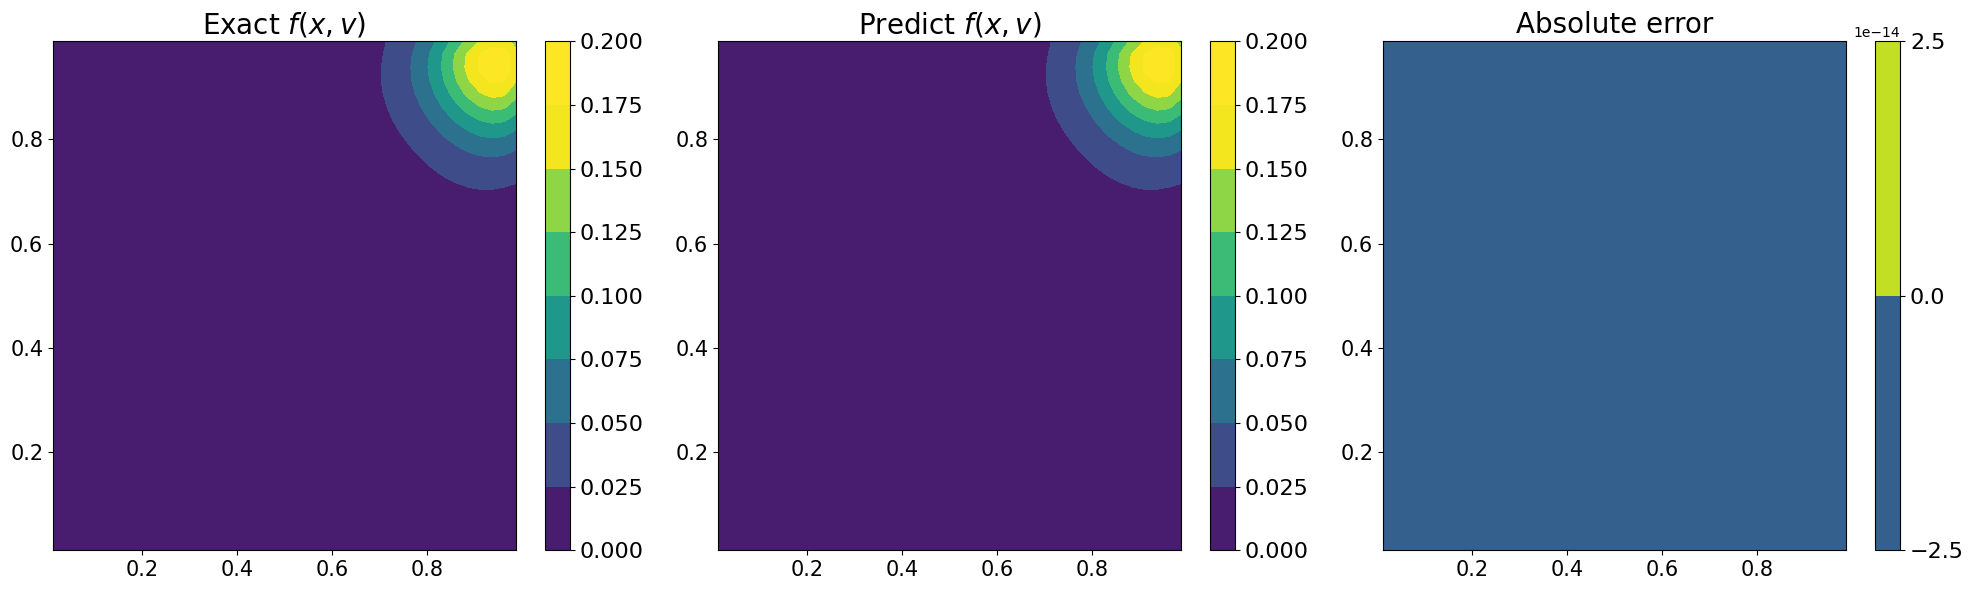

In [20]:
r = np.reshape(a["position_coords"], (40, 40, 2))
plot_phi(r, phi, phi)